<a href="https://colab.research.google.com/github/sahoodibyaranjan/Colabfiles/blob/main/MAZE_SIMULATOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:
%cd /content/drive/My Drive/Colab Notebooks


/content/drive/My Drive/Colab Notebooks


In [3]:
%ls

ANN_numpy.ipynb   maze_100.png  MAZE_SIMULATOR.ipynb  webscraping.ipynb
image_test.ipynb  maze_10.png   Monalisa.ipynb
image_test.py     maze_1.png    Untitled3.ipynb
maze_0.png        maze_210.png  Untitled4.ipynb


In [4]:
!pwd

/content/drive/My Drive/Colab Notebooks


In [5]:
import math
from PIL import Image, ImageDraw
from IPython.display import display

scalefactor = 40
border = 5
markersize = 3
Linewidth = 2

def coord(x):
  if type(x) is list:
    return [coord(elem) for elem in x]
  elif type(x) is tuple:
    return tuple(coord(elem) for elem in x)
  else:
    return int(scalefactor*x) + border

def marker(x):
  return list(i - markersize for i in coord(x)) + list(i + markersize for i in coord(x))

def showmaze(m,i):
  width = m['dimensions'][0]
  height = m['dimensions'][1]
  img = Image.new('RGB', (int(width*scalefactor) + 2*border , int(height*scalefactor) + 2*border), 'white')
  img1 = ImageDraw.Draw(img)
  img1.rectangle(coord([0.0, 0.0, width, height]), None, 'black')
  img1.ellipse(marker(m['position']), 'black')
  img1.ellipse(marker(m['goal']), 'red')
  for obstacle in m['obstacles']:
    img1.line(coord(obstacle), 'black', Linewidth)
  mazeNamePNG = "maze_" + str(i) + ".png"
  img.save(mazeNamePNG)
  display(img)

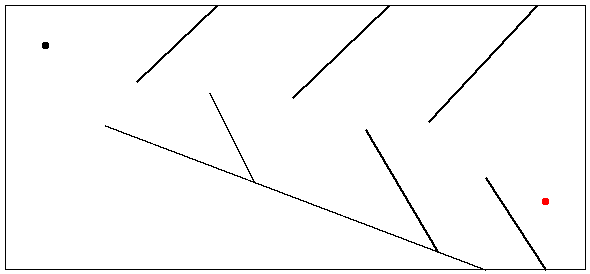

In [6]:
mediumMaze = {
    'dimensions': (14.5, 6.6),

    # obstacles are lines specified as [(x1,y1),(x2,y2)],
    #   where (0,0) is the top-left corner of the world
    # the four walls around the world are implicit and don't need to be specified
    'obstacles': [[(2.5, 3.0),(12.0, 6.6)], [(5.1, 2.2), (6.2, 4.4)],
                  [(9.0, 3.1), (10.8, 6.15)], [(12.0, 4.3), (13.5, 6.6)],
                  [(3.3, 1.9), (5.3, 0.0)], [(7.2, 2.3), (9.6, 0.0)],
                  [(10.6, 2.9), (13.3, 0.0)]],
   
    'position': (1.0, 1.0),
    'heading': 0, # in radians. 0 is to the right (+x axis); increasing heading rotates clockwise
    'goal': (13.5, 4.9),
}

showmaze(mediumMaze,0)

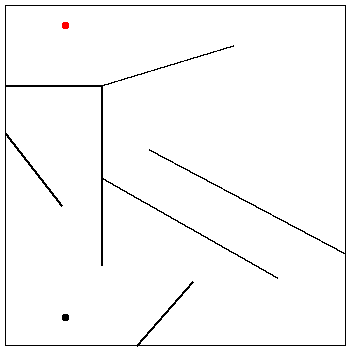

In [7]:
hardMaze = {
    'dimensions': (8.5, 8.5),

    'obstacles': [[(0.0, 2.0), (2.4, 2.0)], [(2.4, 2.0), (5.7, 1.0)],
                  [(2.4, 2.0), (2.4, 6.5)], [(0.0, 3.2), (1.4, 5.0)],
                  [(2.4, 4.3), (6.8, 6.8)], [(3.3, 8.5), (4.7, 6.9)],
                  [(3.6, 3.6), (8.5, 6.2)]],
   
    'position': (1.5, 7.8),
    'heading': 0,
    'goal': (1.5, 0.5),
}

showmaze(hardMaze,0)

In [ ]:
from shapely.geometry import Point, LineString
import copy

def sqDistance(pos1, pos2):
  return (pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2

def isGoal(state):
  return sqDistance(state['position'], state['goal']) < sqEpsilon

# direction a given offset from the current heading, after normalizing (all in radians)
def newHeading(currentHeading, amount):
  return (currentHeading + amount) % (math.pi * 2.0)

# distance to the nearest obstacle in a given direction
def rangeSensor(pos, direction, obstacles, maxDist):
  pos2 = (pos[0] + math.cos(direction) * maxDist,
          pos[1] + math.sin(direction) * maxDist)
  testray = LineString([pos, pos2])
  collisions = [testray.intersection(obstacle) for obstacle in obstacles]
  posPt = Point(pos[0], pos[1])
  distances = [posPt.distance(c) for c in collisions if c]
  return min(distances)



In [77]:
rangeSensorDirections= np.array([[-math.pi/2], [-math.pi/4], [0], [math.pi/4], [math.pi/2], [math.pi]])
#rangeSensorDirections = np.array(x)
#rangeSensorDirections.resize((6,5))
x = np.pad(rangeSensorDirections, (0, 3), 'constant')
print(x)
print(rangeSensorDirections)
#print(type(x))
wedgeSensors =np.array([[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
#wedgeSensors.resize((5,6))
#y = [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]]
#wedgeSensors = np.array(y)
#print(wedgeSensors)
#sensors = rangeSensorDirections + wedgeSensors
#np.pad(sensors, [(0, 1), (0, 1)], mode='constant', constant_values=0)
#sensors = [[-math.pi/2, -math.pi/4, 0, math.pi/4, math.pi/2, math.pi],[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]]
#print(sensors)
#result = np.zeros(wedgeSensors.shape)
#result[:rangeSensorDirections.shape[0],:rangeSensorDirections.shape[1]] = rangeSensorDirections

[[-1.57079633  0.          0.          0.        ]
 [-0.78539816  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.78539816  0.          0.          0.        ]
 [ 1.57079633  0.          0.          0.        ]
 [ 3.14159265  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[-1.57079633]
 [-0.78539816]
 [ 0.        ]
 [ 0.78539816]
 [ 1.57079633]
 [ 3.14159265]]


In [13]:
import random
import numpy as np


In [ ]:
np.random.seed(0)
class Layer_Dense:
  def __init__(self, n_inputs, n_neurons):
    self.weights = np.random.rand(n_inputs, n_neurons)
    self.biases = np.zeros((1, n_neurons))
  def forward(self, inputs):
    self.output = np.dot(inputs, self.weights) + self.biases
  

layer1 = Layer_Dense(10,12)
layer2 = Layer_Dense(12, 2)
layer1.forward(sensors)
print(layer1.output)

In [ ]:
result = np.zeros(b.shape)
print(result)

In [43]:
result[:rangeSensorDirections.shape[0],:rangeSensorDirections.shape[1]] = wedgeSensors

IndexError: ignored

In [34]:

print(np.asarray(rangeSensorDirections).shape)
type(rangeSensorDirections)

(1, 6)


list